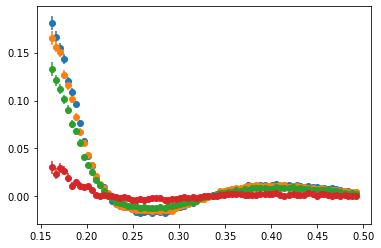

[[Variables]]
    mudc_1:     13.1032970 +/- 0.22629761 (1.73%) (init = 12)
    muds_1:     41.6939462 +/- 0.06192798 (0.15%) (init = 42)
    sigmadc_1:  0.11470803 +/- 0.02615294 (22.80%) (init = 0.1)
    rhom_1:     0.05406632 +/- 0.00176893 (3.27%) (init = 0.1)
    sigmads_1:  0.12 (fixed)
    rhos_1:     2.8 (fixed)
    mudc_2:     13.1032970 +/- 0.22629761 (1.73%) == 'mudc_1'
    muds_2:     41.6939462 +/- 0.06192798 (0.15%) == 'muds_1'
    sigmadc_2:  0.11470803 +/- 0.02615294 (22.80%) == 'sigmadc_1'
    rhom_2:     0.05406632 +/- 0.00176893 (3.27%) (init = 0.1)
    sigmads_2:  0.12000000 +/- 0.00000000 (0.00%) == 'sigmads_1'
    rhos_2:     2.80000000 +/- 0.00000000 (0.00%) == 'rhos_1'
    mudc_3:     13.1032970 +/- 0.22629761 (1.73%) == 'mudc_1'
    muds_3:     41.6939462 +/- 0.06192798 (0.15%) == 'muds_1'
    sigmadc_3:  0.11470803 +/- 0.02615294 (22.80%) == 'sigmadc_1'
    rhom_3:     0.04216080 +/- 0.00143744 (3.41%) (init = 0.1)
    sigmads_3:  0.12000000 +/- 0.00000000 (0.

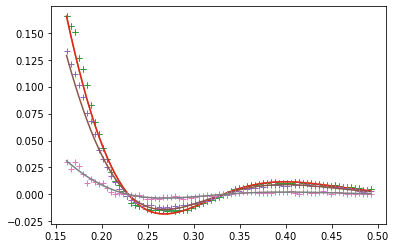

Figure A.1: plot of data and fit (least-squares fit)


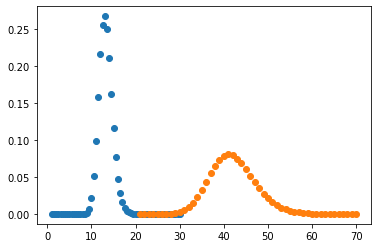

Figure A.2: lognormal distribution of core (blue) and total particle (orange) size (least-squares fit)


In [1]:
# In this notebook the size distributions are extracted from the nuclear-magnetic SANS cross terms
# of a sample of superparamagnetic core-shell iron oxide nanoparticles (surrounded by a silica shell)
# by assuming (i) lognormal distributions for the core and total particle size, that
# (ii) the iron oxide cores are homogeneously magnetized (i.e. magnetic = nuclear core size), 
# and by fitting the field-dependent data with a combination of the form factor for spheres (magnetic) 
# and the form factor for spherical core-shell particles (nuclear part) using a Bayesian approach.
# The results are published in: 
# "The benefits of a Bayesian analysis for the characterization of magnetic nanoparticles"
# https://doi.org/10.1088/1361-6528/aba57b

#==============================================================================
# Import of used packages

import numpy as np
import lmfit as lm
import matplotlib.pyplot as plt
import corner
import emcee

#==============================================================================
# Import of data

q,Iq1,sd1=np.genfromtxt("../data/SANS-5T_data.txt",unpack=True,skip_header=0,skip_footer=0,usecols=(0,1,2)) # 5T
Iq2,sd2=np.genfromtxt("../data/SANS-1T_data.txt",unpack=True,skip_header=0,skip_footer=0,usecols=(1,2)) # 1T
Iq3,sd3=np.genfromtxt("../data/SANS-0.1T_data.txt",unpack=True,skip_header=0,skip_footer=0,usecols=(1,2)) # 0.1T
Iq4,sd4=np.genfromtxt("../data/SANS-0.02T_data.txt",unpack=True,skip_header=0,skip_footer=0,usecols=(1,2)) # 0.02T

#==============================================================================
# Plot of data

plt.errorbar(q,Iq1,sd1, marker='o', ls='None', label='Observed')
plt.errorbar(q,Iq2,sd2, marker='o', ls='None', label='Observed')
plt.errorbar(q,Iq3,sd3, marker='o', ls='None', label='Observed')
plt.errorbar(q,Iq4,sd4, marker='o', ls='None', label='Observed')
plt.xscale('linear')
plt.yscale('linear')
plt.show()

qfit=np.logspace(-3,-1,100)

#==============================================================================
# Create dictionaries for global fit

data = []
data.append(Iq2)
data.append(Iq2)
data.append(Iq3)
data.append(Iq4)

sddata = []
sddata.append(sd2)
sddata.append(sd2)
sddata.append(sd3)
sddata.append(sd4)

N=4

# data and sddata lists are transferred in arrays

ND = len(q) # data points
data = np.array(data)
assert(data.shape) == (N, ND)

sddata = np.array(sddata)
assert(sddata.shape) == (N, ND)

#==============================================================================
# Definition of the fitting function

def lognor(d,sigma,mu): # lognormal distribution
    return 1./(np.sqrt(2.*np.pi)*sigma*d)*np.exp(-0.5*pow((np.log(d)-np.log(mu))/sigma,2))      

def V(d): # volume
    return 1./6.*np.pi*pow(d,3)

def FormNuc(q,ds,dc,rhos,rhoc): # (nuclear) form factor for core-shell spheres, index c = core, index s = shell
    return (3.*V(dc)*(rhoc-rhos)*pow(10,-6)*(np.sin(q*dc*0.5)-q*dc*0.5*np.cos(q*dc*0.5))/pow(q*dc*0.5,3)
            +3.*V(ds)*rhos*pow(10,-6)*(np.sin(q*ds*0.5)-q*ds*0.5*np.cos(q*ds*0.5))/pow(q*ds*0.5,3))

def FormMag(q,dc,rhom): # (magnetic) form factor for a sphere with dm = dc
    return 3.*V(dc)*rhom*pow(10,-6)*(np.sin(q*dc*0.5)-q*dc*0.5*np.cos(q*dc*0.5))/pow(q*dc*0.5,3)

rhoc = 6.9 # nuclear scattering length density (SLD) of the core
pre = pow(10,5) # prefactor; when q is in [1/nm] it's 10^5, when q is in [1/A] it's 10^8. 
                # but this is only relevant for corrected data with I in [1/cm]

dc = np.linspace(1,30,59) # bins of (nuclear = magnetic) core size distribution in [nm]
ds = np.linspace(21,70,50) # bins of total particle size distribution in [nm]  

def residuals(params,i):
    mudc = params['mudc_%i' % (i+1)].value
    muds= params['muds_%i' % (i+1)].value
    sigmads = params['sigmads_%i' % (i+1)].value
    sigmadc = params['sigmadc_%i' % (i+1)].value
    rhos = params['rhos_%i' % (i+1)].value
    rhom = params['rhom_%i' % (i+1)].value  
    
    model  = pre * np.trapz(np.trapz(lognor(dc[np.newaxis, np.newaxis, :],sigmadc,mudc) 
                                   * lognor(ds[np.newaxis, :,np.newaxis],sigmads,muds) 
                                   * FormNuc(q[:, np.newaxis,np.newaxis],ds[np.newaxis, :,np.newaxis],dc[np.newaxis, np.newaxis, :],rhos,rhoc)
                                   * FormMag(q[:, np.newaxis,np.newaxis],dc[np.newaxis, np.newaxis, :],rhom), x=dc), x=ds)
    return model

def objective(params): # objective function which will be minimized; normalized to sigma
    ndata, nx = data.shape
    resid = 0.0*data[:]
    for i in range(ndata):
        resid[i, :] = (residuals(params, i) - data[i, :])/sddata[i, :]

    return resid.flatten()

params = lm.Parameters()

for iy, y in enumerate(data): # introduction of fitting parameters. lmfit allows to set priors/boundaries
    params.add('mudc_%i' % (iy+1), value=12., vary=True, min=0.) # median value of the core size (log-normal) distribution in [nm]
    params.add('muds_%i' % (iy+1), value=42., vary=True, min=0.) # median value of the total particle size (log-normal) distribution in [nm]
    params.add('sigmadc_%i' % (iy+1), value=0.1, vary=True, min=0.) # broadness of the total particle size (log-normal) distribution  
    params.add('rhom_%i' % (iy+1), value=0.1, vary=True, min=0.) # field-dependent magnetic scattering length density of the core   
    params.add('sigmads_%i' % (iy+1), value=0.12, vary=False, min=0.) # broadness of the core size (log-normal) distribution
    params.add('rhos_%i' % (iy+1), value=2.8, vary=False, min=0.) # nuclear scattering length density of the shell  

# Global fit parameters are defined (same result for the Fit of all N data sets)  

for iy in np.arange(1,N):
    params['mudc_%i' % (iy+1)].expr='mudc_1'

for iy in np.arange(1,N):
    params['muds_%i' % (iy+1)].expr='muds_1'

for iy in np.arange(1,N):
    params['sigmadc_%i' % (iy+1)].expr='sigmadc_1'

for iy in np.arange(1,N):
    params['sigmads_%i' % (iy+1)].expr='sigmads_1'   

for iy in np.arange(1,N):
    params['rhos_%i' % (iy+1)].expr='rhos_1'    

#==============================================================================
#==============================================================================
# A) Standard least-squares fit
#==============================================================================
#==============================================================================
# A.1) Fit of data
    
res1 = lm.minimize(objective, params, method='leastsq') # leastsq = Levenberg-Marquardt

lm.report_fit(res1.params)

#==============================================================================
# A.2) Plot of results

plt.figure()
for i in range(N):
    y_fit = residuals(res1.params, i)
    plt.plot(q, data[i, :], '+', q, y_fit, '-')

plt.show() 
print('Figure A.1: plot of data and fit (least-squares fit)')

plt.plot(dc,lognor(dc,res1.params['sigmadc_1'].value,res1.params['mudc_1'].value),'o')
plt.plot(ds,lognor(ds,res1.params['sigmads_1'].value,res1.params['muds_1'].value),'o')
plt.show()
print('Figure A.2: lognormal distribution of core (blue) and total particle (orange) size (least-squares fit)')


100%|████████████████████████████████████| 1000/1000 [1:10:16<00:00,  4.22s/it]


The chain is shorter than 50 times the integrated autocorrelation time for 7 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [ 49.38326458  48.92486412  50.35355852  47.76537652  47.87665124
  47.46107368  50.34869803]
[[Variables]]
    mudc_1:     13.1131041 +/- 0.17911209 (1.37%) (init = 13.1033)
    muds_1:     41.6921084 +/- 0.04931812 (0.12%) (init = 41.69395)
    sigmadc_1:  0.11364658 +/- 0.02179309 (19.18%) (init = 0.114708)
    rhom_1:     0.05397039 +/- 0.00140008 (2.59%) (init = 0.05406632)
    sigmads_1:  0.12 (fixed)
    rhos_1:     2.8 (fixed)
    mudc_2:     13.1131041 == 'mudc_1'
    muds_2:     41.6921084 == 'muds_1'
    sigmadc_2:  0.11364658 == 'sigmadc_1'
    rhom_2:     0.05402342 +/- 0.00138131 (2.56%) (init = 0.05406632)
    sigmads_2:  0.12000000 == 'sigmads_1'
    rhos_2:     2.80000000 == 'rhos_1'
    mudc_3:     13.1131041 == 'mudc_1'
    muds_3:     41.6921084 == 'muds_1'
    sigmadc_3:  0.11364658 == 'sigmadc_1'
    rhom

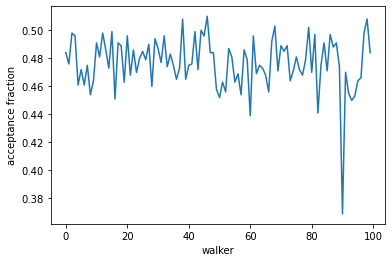

Figure B.1: Acceptance fraction for each walker (should be around 0.5)


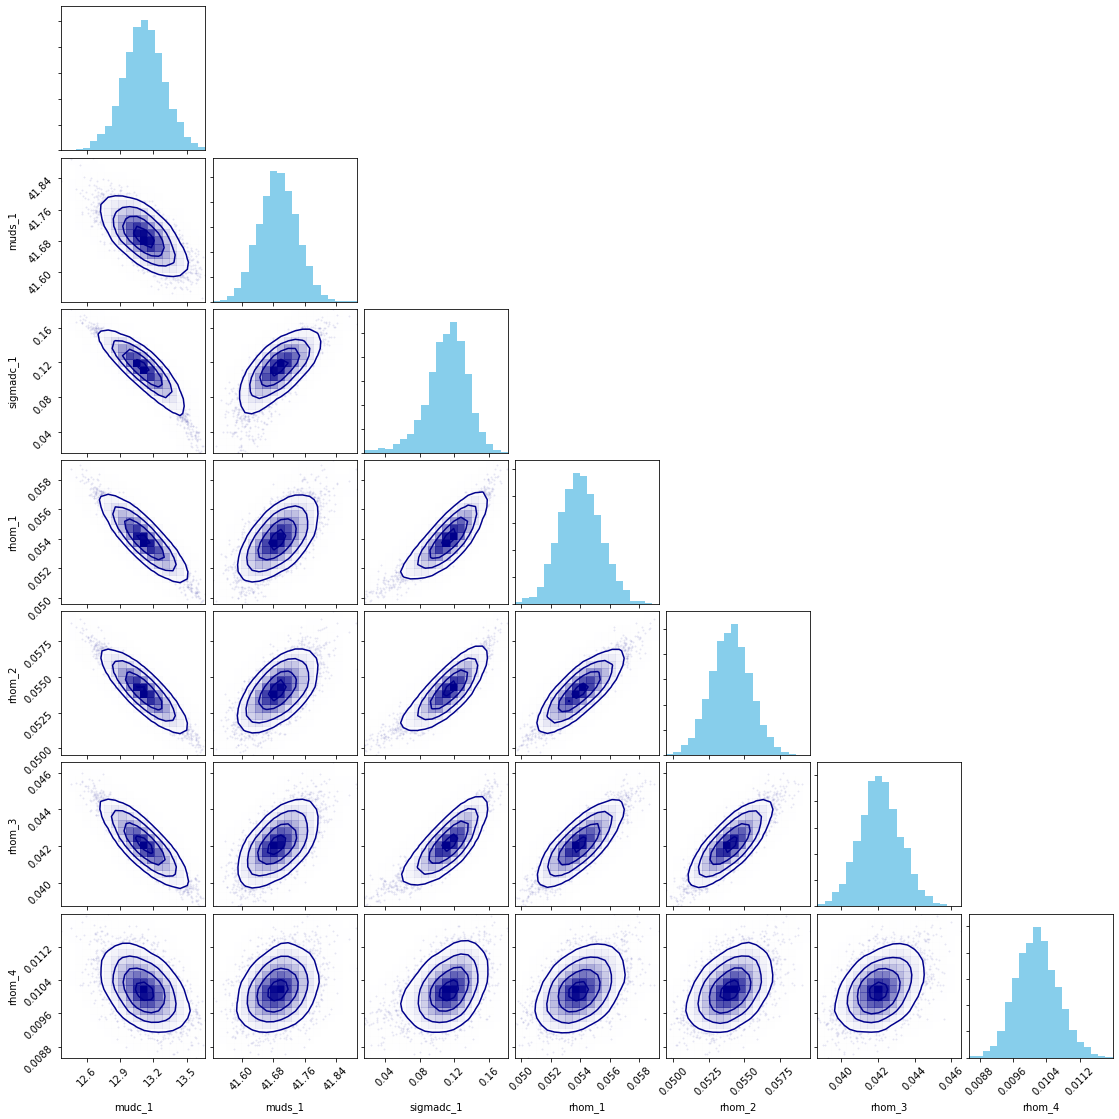

Figure B.2: corner plot of the parameter distributions and cross correlations (Bayes fit)


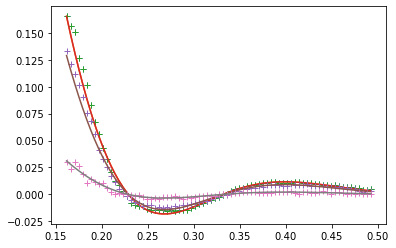

Figure B.3: plot of data and fit (Bayes fit)


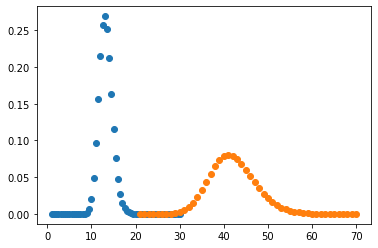

Figure B.4: lognormal distribution of core (blue) and total particle (orange) size (Bayes fit)


In [2]:
#==============================================================================
#==============================================================================
# B) Bayes fit
#==============================================================================
#==============================================================================
# B.1) Fit of data

nwalkers=100 # should be set that it is much larger than number of parameters/variables. 100 is default
steps=1000 # number of samples you would like to draw from the posterior distribution for each of the walkers
burn=300 # Discard this many samples from the start of the sampling regime.
thin=20 # Only accept 1 in every thin samples.
params=res1.params # we use the fit results of the leastsq fit as starting values for the refinement

res2 = lm.minimize(objective, method='emcee', nan_policy='omit', nwalkers=nwalkers, steps=steps, burn=burn, thin=thin, 
                   params=params, is_weighted=True, progress=True)

lm.report_fit(res2.params)

#==============================================================================
# B.2) Plot of results

plt.plot(res2.acceptance_fraction)
plt.xlabel('walker')
plt.ylabel('acceptance fraction')
plt.show()
print('Figure B.1: Acceptance fraction for each walker (should be around 0.5)')

# corner plot
emcee_plot = corner.corner(res2.flatchain, labels=res2.var_names, color ='darkblue', truth_color='black',smooth=True,hist_kwargs=dict(histtype='stepfilled', color='skyblue'))
plt.show()
print('Figure B.2: corner plot of the parameter distributions and cross correlations (Bayes fit)')

plt.figure()
for i in range(N):
    y_fit = residuals(res2.params, i)
    plt.plot(q, data[i, :], '+', q, y_fit, '-')

plt.show() 
print('Figure B.3: plot of data and fit (Bayes fit)')

plt.plot(dc,lognor(dc,res2.params['sigmadc_1'].value,res2.params['mudc_1'].value),'o')
plt.plot(ds,lognor(ds,res2.params['sigmads_1'].value,res2.params['muds_1'].value),'o')
plt.show()
print('Figure B.4: lognormal distribution of core (blue) and total particle (orange) size (Bayes fit)')